In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import scipy.io.wavfile as wf
from peek import peek

from pydub import AudioSegment
from pydub.playback import play

import librosa.display
# rate, data = wf.read('clairvoyant.wav')

In [18]:
orig_filepath = "music/the_story_so_far/The Story So Far 'Small Talk'-LHIVOa-9AgE.wav"
sides_subtracted = 'sides_subtracted.wav'
vocals_isolated = 'vocals_isolated.wav'
vocals_isolated_phased = 'vocals_isolated_phased.wav'
working_dir = 'working_dir'

In [19]:
sound_stereo = AudioSegment.from_file(orig_filepath, format='wav')
os.chdir(working_dir)

In [20]:
sound_L = sound_stereo.split_to_mono()[0]
sound_R = sound_stereo.split_to_mono()[1]
sound_S = sound_L + sound_R.invert_phase()
sound_voice = sound_stereo + sound_S.invert_phase()
sound_voice.export(sides_subtracted, format='wav')

<_io.BufferedRandom name='sides_subtracted.wav'>

In [33]:
y, sr = librosa.load(sides_subtracted)
S_full, phase = librosa.magphase(librosa.stft(y))


(1025, 21342)

In [36]:
print(librosa.stft(y))
print(S_full.shape)

[[ 0.0000000e+00+0.0000000e+00j  1.1587302e-03+0.0000000e+00j
   1.2797138e-02+0.0000000e+00j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 0.0000000e+00+0.0000000e+00j  8.3561422e-04+7.7228044e-04j
  -4.3962444e-03+1.0594573e-02j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 0.0000000e+00-0.0000000e+00j  7.8677920e-05+1.0744844e-03j
  -5.2518947e-03-6.5088393e-03j ...  0.0000000e+00-0.0000000e+00j
   0.0000000e+00-0.0000000e+00j  0.0000000e+00-0.0000000e+00j]
 ...
 [ 0.0000000e+00+0.0000000e+00j  1.0854294e-09-4.4767838e-09j
  -1.1980137e-08+2.6493778e-08j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 0.0000000e+00+0.0000000e+00j  3.1780298e-09-2.2314048e-09j
  -1.5992601e-08-2.9446266e-08j ...  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 0.0000000e+00+0.0000000e+00j  3.60632

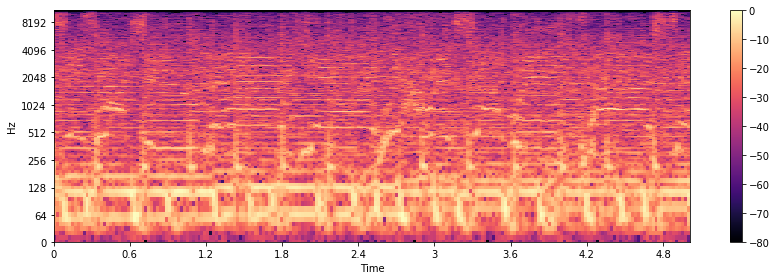

In [23]:
idx = slice(*librosa.time_to_frames([30,35], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

In [24]:
S_filter = librosa.decompose.nn_filter(S_full, aggregate=np.median, metric='cosine', width=int(librosa.time_to_frames(2, sr=sr)))
S_filter = np.minimum(S_full, S_filter)

In [25]:
margin_i, margin_v = 2, 10
power = 2
mask_i = librosa.util.softmask(S_filter, margin_i * (S_full - S_filter), power=power)
mask_v = librosa.util.softmask(S_full - S_filter, margin_v * S_filter, power=power)
S_foreground = mask_v * S_full
S_background = mask_i * S_full

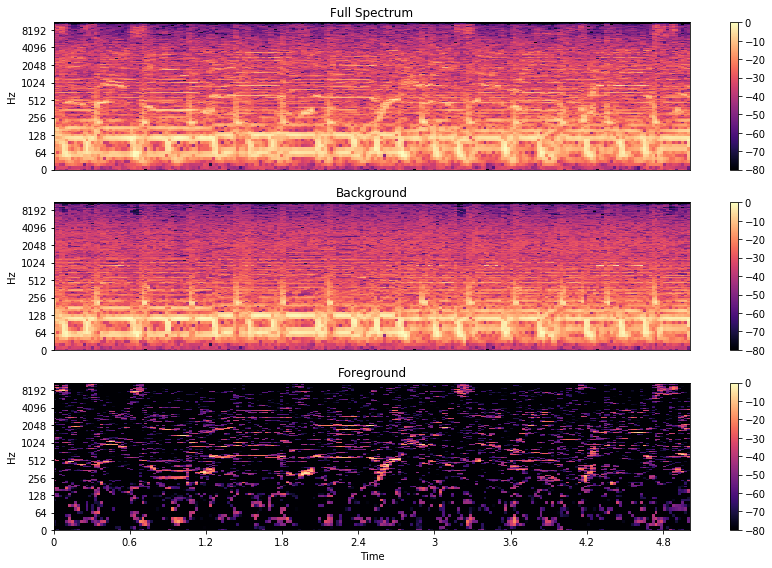

In [26]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max), y_axis='log', sr=sr)
plt.title('Full Spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max), y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [27]:
sf.write(vocals_isolated, librosa.istft(S_foreground), sr, subtype='PCM_24')

D_foreground = S_foreground * phase
sf.write(vocals_isolated_phased, librosa.istft(D_foreground), sr, subtype='PCM_24')

NameError: name 'subtype' is not defined